In [2]:
import pandas as pd
import numpy as np

In [4]:
df=pd.read_csv('AirBnb.csv',index_col=0)
df.head()

,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,...,weibo,reviews,selfie,google,identity_manual,manual_offline,facebook,manual_online,longitude,latitude
0,0.0,0.0,5,1.5,2,2.0,145,0.0,110.0,1,...,0,0,0,0,0,0,0,0,-73.925881,40.696476
1,1.0,1.0,4,1.0,2,1.0,199,399.0,50.0,2,...,0,1,0,0,0,0,1,0,-73.967754,40.676073
2,1.0,1.0,3,1.0,1,1.0,165,0.0,75.0,2,...,0,1,0,0,0,0,0,0,-73.967754,40.676073
3,3.0,3.0,2,1.0,1,1.0,59,0.0,49.0,1,...,0,1,0,0,0,0,0,0,-74.002817,40.733584
4,6.0,6.0,2,1.5,1,1.0,48,0.0,25.0,1,...,0,0,0,0,0,0,0,0,-73.935376,40.731912


In [5]:
X=df.drop('price',axis=1)
y=df['price']

In [6]:
numerical_cols = X.select_dtypes(exclude='object').columns
categorical_cols = X.select_dtypes(include='object').columns

In [7]:
X_dummy=pd.get_dummies(X,columns=list(categorical_cols),drop_first=True)

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_dummy,y,test_size=0.2,random_state=42)

### With Boxcox Transformation

Conduct boxcox transformation to dependent variable before modeling and un-boxcox predicted value to evaluate the model

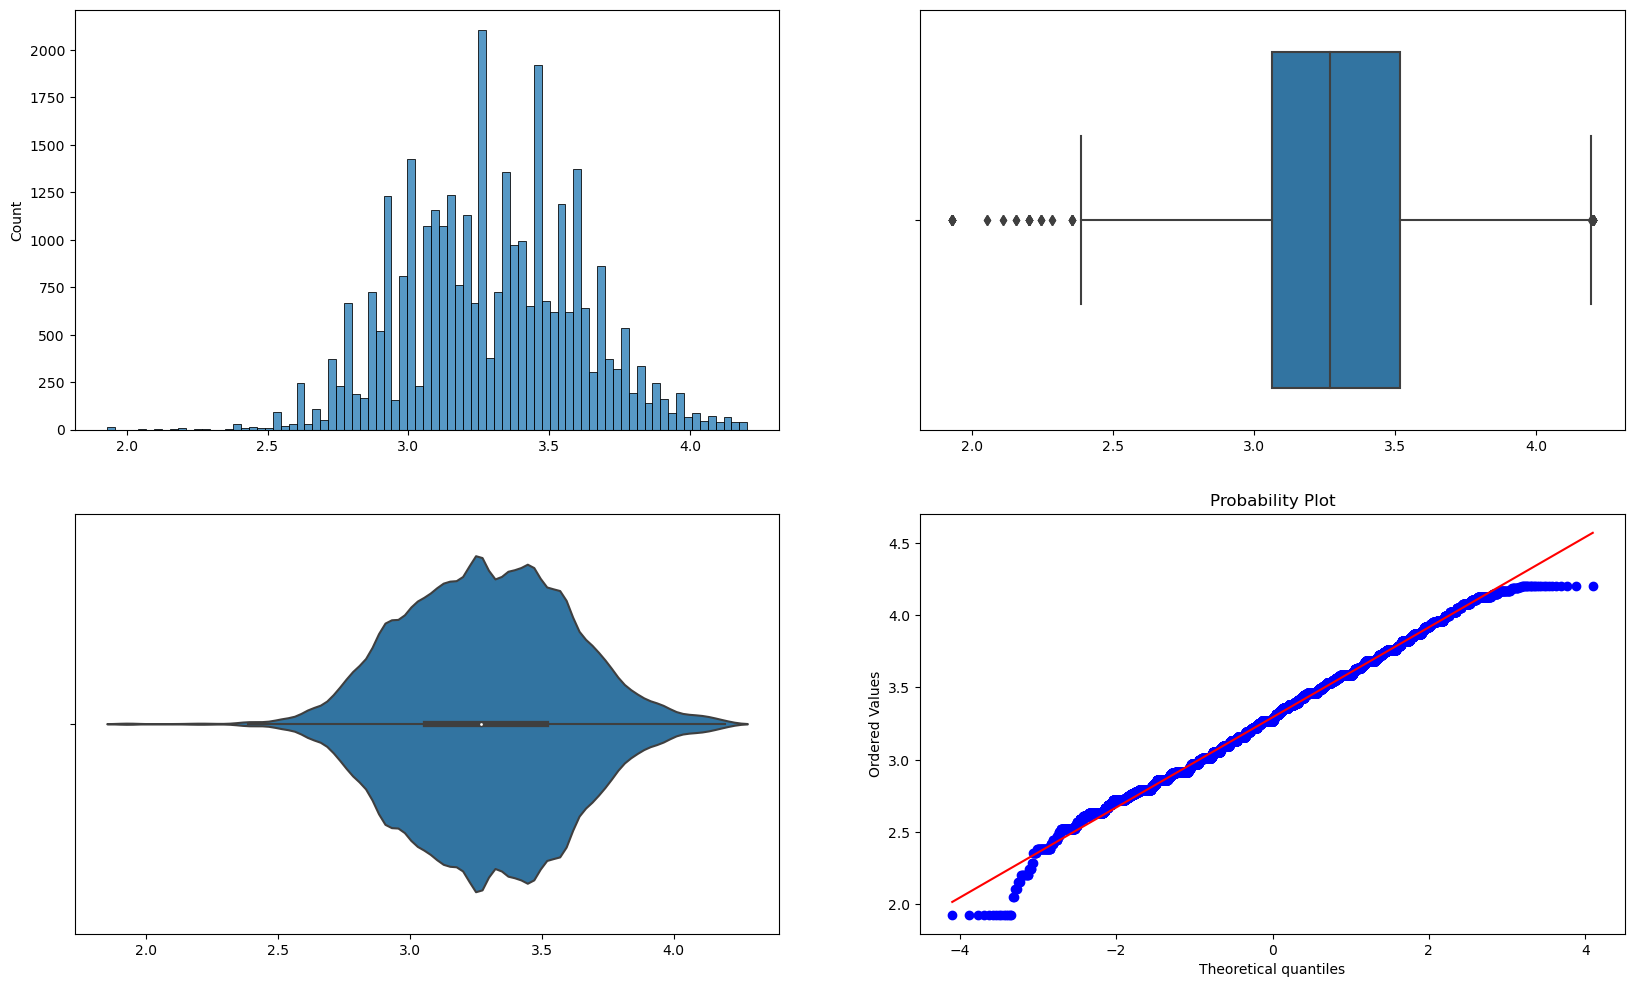

In [18]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

y_train_transformed, lambda_=boxcox(y_train)

fig,ax=plt.subplots(2,2,figsize=(20,12))
ax1=sns.histplot(x=y_train_transformed,ax=ax[0,0])
ax2=sns.boxplot(x=y_train_transformed,ax=ax[0,1])
ax3=sns.violinplot(x=y_train_transformed,ax=ax[1,0])
ax4=probplot(y_train_transformed,plot=pylab)
pylab.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,make_scorer
from math import sqrt

In [9]:
def rmse_invboxcox(y_pred,y_test):
    return np.sqrt(mean_squared_error(y_test,inv_boxcox(y_pred,lambda_)))

rmse_scorer=make_scorer(rmse_invboxcox,greater_is_better=False)

def no_scaling(X):
    return X

no_scaling_transformer=FunctionTransformer(no_scaling)

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

scalers=[StandardScaler(),MinMaxScaler(),RobustScaler(),no_scaling_transformer]

**Linear Regression**

In [155]:
from sklearn.linear_model import LinearRegression

param_grid={
    'scaler':scalers,
}

pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('reg', LinearRegression())
])

grid_search=GridSearchCV(pipeline,param_grid,cv=5,scoring=rmse_scorer)

grid_search.fit(X_train, y_train_transformed)

y_pred_transformed=grid_search.predict(X_test)

test_rmse=rmse(inv_boxcox(y_pred_transformed,lambda_),y_test)

print("Best parameters: ", grid_search.best_params_)
print("RMSE on test dataset: ", test_rmse)

Best parameters:  {'scaler': RobustScaler()}

RMSE on test dataset:  85.36004892012689


**Lasso Regression**

In [156]:
from sklearn.linear_model import Lasso

param_grid={
    'scaler':scalers,
    'lasso__alpha':[0.001,0.01,0.1,1,10,100]
}

pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('lasso', Lasso())
])

grid_search=GridSearchCV(pipeline,param_grid,cv=5,scoring=rmse_scorer)

grid_search.fit(X_train, y_train_transformed)

y_pred_transformed=grid_search.predict(X_test)

test_rmse=rmse(inv_boxcox(y_pred_transformed,lambda_),y_test)

print("Best parameters: ", grid_search.best_params_)
print("RMSE on test dataset: ", test_rmse)

/Users/maiiam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.199e+01, tolerance: 2.574e-01

  model = cd_fast.enet_coordinate_descent(

/Users/maiiam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.767e+01, tolerance: 2.545e-01

  model = cd_fast.enet_coordinate_descent(

/Users/maiiam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regul

Best parameters:  {'lasso__alpha': 0.001, 'scaler': StandardScaler()}

RMSE on test dataset:  84.01998995200904


**KNN**

In [157]:
from sklearn.neighbors import KNeighborsRegressor

param_grid={
    'scaler':scalers,
    'knn__n_neighbors': range(1, 30)
}

pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('knn', KNeighborsRegressor())
])

grid_search=GridSearchCV(pipeline,param_grid,cv=5,scoring=rmse_scorer)

grid_search.fit(X_train, y_train_transformed)

y_pred_transformed=grid_search.predict(X_test)

test_rmse=rmse(inv_boxcox(y_pred_transformed,lambda_),y_test)

print("Best parameters: ", grid_search.best_params_)
print("RMSE on test dataset: ", test_rmse)

Best parameters:  {'knn__n_neighbors': 1, 'scaler': RobustScaler()}

RMSE on test dataset:  89.65817745775746


**Random Forest**

In [19]:
from sklearn.ensemble import RandomForestRegressor

param_grid={
    'scaler':scalers,
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [5, 10, 15]
}

pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('rf', RandomForestRegressor())
])

grid_search=GridSearchCV(pipeline,param_grid,cv=5,scoring=rmse_scorer)

grid_search.fit(X_train, y_train_transformed)

y_pred_transformed=grid_search.predict(X_test)

test_rmse=rmse(inv_boxcox(y_pred_transformed,lambda_),y_test)

print("Best parameters: ", grid_search.best_params_)
print("RMSE on test dataset: ", test_rmse)

Best parameters:  {'rf__max_depth': 15, 'rf__n_estimators': 200, 'scaler': RobustScaler()}

RMSE on test dataset:  67.41837806922095


### Without Boxcox Transformation

In [20]:
def rmse_untransformed(y_pred,y_test):
    return np.sqrt(mean_squared_error(y_test,y_pred))

rmse_untransformed_scorer=make_scorer(rmse_untransformed,greater_is_better=False)

**Linear Regression**

In [23]:
from sklearn.linear_model import LinearRegression

param_grid={
    'scaler':scalers,
}

pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('reg', LinearRegression())
])

grid_search=GridSearchCV(pipeline,param_grid,cv=5,scoring=rmse_untransformed_scorer)

grid_search.fit(X_train, y_train)

y_pred=grid_search.predict(X_test)

test_rmse=rmse(y_pred,y_test)

print("Best parameters: ", grid_search.best_params_)
print("RMSE on test dataset: ", test_rmse)

Best parameters:  {'scaler': RobustScaler()}

RMSE on test dataset:  74.54926061432164


**Lasso Regression**

In [24]:
from sklearn.linear_model import Lasso

param_grid={
    'scaler':scalers,
    'lasso__alpha':[0.001,0.01,0.1,1,10,100]
}

pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('lasso', Lasso())
])

grid_search=GridSearchCV(pipeline,param_grid,cv=5,scoring=rmse_untransformed_scorer)

grid_search.fit(X_train, y_train)

y_pred=grid_search.predict(X_test)

test_rmse=rmse(y_pred,y_test)

print("Best parameters: ", grid_search.best_params_)
print("RMSE on test dataset: ", test_rmse)

/Users/maiiam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.768e+07, tolerance: 3.297e+04

  model = cd_fast.enet_coordinate_descent(

/Users/maiiam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.633e+07, tolerance: 3.224e+04

  model = cd_fast.enet_coordinate_descent(

/Users/maiiam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regul

Best parameters:  {'lasso__alpha': 0.01, 'scaler': MinMaxScaler()}

RMSE on test dataset:  74.4106062850996


**KNN**

In [25]:
from sklearn.neighbors import KNeighborsRegressor

param_grid={
    'scaler':scalers,
    'knn__n_neighbors': range(1, 30)
}

pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('knn', KNeighborsRegressor())
])

grid_search=GridSearchCV(pipeline,param_grid,cv=5,scoring=rmse_untransformed_scorer)

grid_search.fit(X_train, y_train)

y_pred=grid_search.predict(X_test)

test_rmse=rmse(y_pred,y_test)

print("Best parameters: ", grid_search.best_params_)
print("RMSE on test dataset: ", test_rmse)

Best parameters:  {'knn__n_neighbors': 8, 'scaler': RobustScaler()}

RMSE on test dataset:  75.19830780138534


**Random Forest**

In [26]:
from sklearn.ensemble import RandomForestRegressor

param_grid={
    'scaler':scalers,
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 15,20]
}

pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('rf', RandomForestRegressor())
])

grid_search=GridSearchCV(pipeline,param_grid,cv=5,scoring=rmse_untransformed_scorer)

grid_search.fit(X_train, y_train)

y_pred=grid_search.predict(X_test)

test_rmse=rmse(y_pred,y_test)

print("Best parameters: ", grid_search.best_params_)
print("RMSE on test dataset: ", test_rmse)

Best parameters:  {'rf__max_depth': 20, 'rf__n_estimators': 300, 'scaler': StandardScaler()}

RMSE on test dataset:  63.548250616728374


XGboost is relatively robust to skewed data, thus testing the performance of xgboost

**XGBoost**

In [30]:
from xgboost import XGBRegressor

xgb=XGBRegressor(n_estimators=100,learning_rate=0.1)

xgb.fit(X_train,y_train)

y_pred = xgb.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, y_pred))

print("RMSE:", rmse)

RMSE: 61.44855831272524


Xgboost Model gives out the best performance.